In [1]:
pip install -r "requirement.txt"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3
import pandas as pd
db_file = "Fund.db"
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'PYPL', 'ADBE', 'INTC']#tickers contenus dans MAIN_DATA_FRAME

start_date = "01/09/2022"#toute la periode start date (pour tout telecharger dun coup) + 3 mois avant
end_date = "31/12/2024"#pareil

## 1. Creation et peuplement de la base

In [3]:
from base_builder import DatabaseBuilder

In [4]:
db_manager = DatabaseBuilder(db_file)
db_manager.create_tables()
db_manager.insert_clients_data(12)
db_manager.insert_managers_data(3)

Tables created successfully.
12 clients insérés avec succès dans la table 'Clients'.
3 managers insérés avec succès dans la table 'Managers'.


In [5]:
db_manager.get_investment_amount_by_risk_type()
db_manager.insert_initial_cash_portfolios(start_date)


Résumé des investissements par risk type:
--------------------------------------------------
Risk Type: HY_EQUITY
Nombre de clients: 1
Montant total investi: 5,649,334.98 €
--------------------------------------------------
Risk Type: LOW_RISK
Nombre de clients: 7
Montant total investi: 33,825,802.20 €
--------------------------------------------------
Risk Type: LOW_TURNOVER
Nombre de clients: 4
Montant total investi: 25,881,128.15 €
--------------------------------------------------
Montants initiaux en cash insérés avec succès dans la table Portfolios.


## 2. Collecte et traitement des datas

In [6]:
from data_collector import GetData

In [7]:
gdata = GetData(tickers, start_date, end_date)
gdata.main_data_frame()#on cree le dataframe avec TOUS les actifs TOUTE la periode
#il manquerait le traitement des datas

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,IMPORT_DATE,PRICE,TICKER,SECTOR
0,2022-09-01,155.885895,AAPL,Technology
1,2022-09-02,153.764160,AAPL,Technology
2,2022-09-06,152.500946,AAPL,Technology
3,2022-09-07,153.912201,AAPL,Technology
4,2022-09-08,152.431900,AAPL,Technology
...,...,...,...,...
5845,2024-12-23,20.200001,INTC,Technology
5846,2024-12-24,20.400000,INTC,Technology
5847,2024-12-26,20.440001,INTC,Technology
5848,2024-12-27,20.299999,INTC,Technology


# 3. Periode avant t = 0 (Periode de "test")

On peuple Products avec des trois mois de donnees avant la periode d'evaluation du fonds (qui commence le 01/01/2023)

In [8]:
from base_update import BaseUpdate 
sub_start_date = "01/09/2022"#chaque semaine, les strat lancent la fct et definissent les sub périodes
#de cette maniere, products ne contient que la data jusqu'à la date t (no forward looking sur nos strats)
sub_end_date = "29/12/2022"

In [9]:
B_udt = BaseUpdate(tickers, sub_start_date, sub_end_date, db_file)
B_udt.update_products()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 820 new records into Products table for the period 01/09/2022 to 29/12/2022


### Initialisation des portefeuilles en fonction du cash initial

Pour la strategie HY equity, on prend les 5 tickers les plus performants de la periode (allant du 01/09/2022 au 30/12/2022)

In [10]:
B_udt.initialisation_portefeuille_HY()

Cash disponible : 5,649,334.98

Tickers sélectionnés pour l'initialisation :
AAPL: 151.33 (Rendement: -2.92%)
NVDA: 13.48 (Rendement: -3.13%)
PYPL: 83.58 (Rendement: -9.80%)
INTC: 27.05 (Rendement: -10.48%)
MSFT: 227.28 (Rendement: -10.86%)
→ Achat de 7466 unités de AAPL @ 151.33
→ Achat de 83802 unités de NVDA @ 13.48
→ Achat de 13518 unités de PYPL @ 83.58
→ Achat de 41770 unités de INTC @ 27.05
→ Achat de 4971 unités de MSFT @ 227.28

Cash restant : 164.63


# 4. Execution des strategies

In [11]:
from strategies import RunAllStrat
start_date2="01/01/2023"
end_date2="31/12/2023"
b=RunAllStrat(db_file,start_date2,end_date2,tickers)
b.run()

[*********************100%***********************]  1 of 1 completed


Début de la simulation historique du 01/01/2023 au 31/12/2023

=== Simulation pour le lundi 02/01/2023 ===
Exécution de la stratégie pour la date historique : 02/01/2023
Updating products for historical week: 26/12/2022 to 01/01/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 40 new records into Products table for the period 26/12/2022 to 01/01/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 2959 x PYPL @ 71.22
→ Transaction effectuée : Sell 1144 x AAPL @ 128.44
→ Transaction effectuée : Buy 8573 x NVDA @ 14.60
→ Transaction effectuée : Sell 2469 x INTC @ 25.49
→ Transaction effectuée : Buy 32 x MSFT @ 235.48
Cash restant : 288,042.25

=== Simulation pour le lundi 09/01/2023 ===
Exécution de la stratégie pour la date historique : 09/01/2023
Updating products for historical week: 02/01/2023 to 08/01/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 40 new records into Products table for the period 02/01/2023 to 08/01/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 2311 x PYPL @ 71.22
→ Transaction effectuée : Sell 969 x AAPL @ 128.44
→ Transaction effectuée : Buy 9450 x NVDA @ 14.60
→ Transaction effectuée : Sell 2323 x INTC @ 25.49
→ Transaction effectuée : Buy 32 x MSFT @ 235.48
Cash restant : 490,765.98

=== Simulation pour le lundi 16/01/2023 ===
Exécution de la stratégie pour la date historique : 16/01/2023
Updating products for historical week: 09/01/2023 to 15/01/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 09/01/2023 to 15/01/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 1805 x PYPL @ 71.22
→ Transaction effectuée : Sell 820 x AAPL @ 128.44
→ Transaction effectuée : Buy 10417 x NVDA @ 14.60
→ Transaction effectuée : Sell 2185 x INTC @ 25.49
→ Transaction effectuée : Buy 32 x MSFT @ 235.48
Cash restant : 620,678.11

=== Simulation pour le lundi 23/01/2023 ===
Exécution de la stratégie pour la date historique : 23/01/2023
Updating products for historical week: 16/01/2023 to 22/01/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 40 new records into Products table for the period 16/01/2023 to 22/01/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 1410 x PYPL @ 71.22
→ Transaction effectuée : Sell 695 x AAPL @ 128.44
→ Transaction effectuée : Buy 11483 x NVDA @ 14.60
→ Transaction effectuée : Sell 2056 x INTC @ 25.49
→ Transaction effectuée : Buy 32 x MSFT @ 235.48
Cash restant : 687,550.31

=== Simulation pour le lundi 30/01/2023 ===
Exécution de la stratégie pour la date historique : 30/01/2023
Updating products for historical week: 23/01/2023 to 29/01/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 23/01/2023 to 29/01/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 33789 x NVDA @ 20.35
→ Transaction effectuée : Sell 516 x PYPL @ 81.83
→ Transaction effectuée : Sell 188 x AAPL @ 144.25
→ Transaction effectuée : Buy 211 x MSFT @ 243.66
→ Transaction effectuée : Buy 80 x INTC @ 27.15
Cash restant : 15,758.98

=== Simulation pour le lundi 06/02/2023 ===
Exécution de la stratégie pour la date historique : 06/02/2023
Updating products for historical week: 30/01/2023 to 05/02/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 30/01/2023 to 05/02/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 807 x NVDA @ 19.52
→ Transaction effectuée : Sell 480 x PYPL @ 81.49
→ Transaction effectuée : Sell 218 x AAPL @ 142.63
→ Transaction effectuée : Buy 212 x MSFT @ 243.32
→ Transaction effectuée : Buy 197 x INTC @ 27.25
Cash restant : 13,262.04

=== Simulation pour le lundi 13/02/2023 ===
Exécution de la stratégie pour la date historique : 13/02/2023
Updating products for historical week: 06/02/2023 to 12/02/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 06/02/2023 to 12/02/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 679 x NVDA @ 19.52
→ Transaction effectuée : Sell 429 x PYPL @ 81.49
→ Transaction effectuée : Sell 205 x AAPL @ 142.63
→ Transaction effectuée : Buy 220 x MSFT @ 243.32
→ Transaction effectuée : Buy 199 x INTC @ 27.25
Cash restant : 5,252.51

=== Simulation pour le lundi 20/02/2023 ===
Exécution de la stratégie pour la date historique : 20/02/2023
Updating products for historical week: 13/02/2023 to 19/02/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 13/02/2023 to 19/02/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 269 x NVDA @ 19.52
→ Transaction effectuée : Sell 383 x PYPL @ 81.49
→ Transaction effectuée : Sell 192 x AAPL @ 142.63
→ Transaction effectuée : Buy 229 x MSFT @ 243.32
→ Transaction effectuée : Buy 105 x INTC @ 27.25
Cash restant : 15.50

=== Simulation pour le lundi 27/02/2023 ===
Exécution de la stratégie pour la date historique : 27/02/2023
Updating products for historical week: 20/02/2023 to 26/02/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 40 new records into Products table for the period 20/02/2023 to 26/02/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 623 x PYPL @ 73.55
→ Transaction effectuée : Sell 3136 x INTC @ 24.54
→ Transaction effectuée : Buy 289 x MSFT @ 245.32
→ Transaction effectuée : Sell 129 x AAPL @ 145.25
Cash restant : 70,625.86

=== Simulation pour le lundi 06/03/2023 ===
Exécution de la stratégie pour la date historique : 06/03/2023
Updating products for historical week: 27/02/2023 to 05/03/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 27/02/2023 to 05/03/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 3044 x NVDA @ 23.20
→ Transaction effectuée : Sell 501 x PYPL @ 73.60
→ Transaction effectuée : Sell 3069 x INTC @ 24.33
→ Transaction effectuée : Buy 309 x MSFT @ 245.52
→ Transaction effectuée : Sell 110 x AAPL @ 145.94
Cash restant : 51,752.85

=== Simulation pour le lundi 13/03/2023 ===
Exécution de la stratégie pour la date historique : 13/03/2023
Updating products for historical week: 06/03/2023 to 12/03/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 06/03/2023 to 12/03/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 2231 x NVDA @ 23.20
→ Transaction effectuée : Sell 405 x PYPL @ 73.60
→ Transaction effectuée : Sell 2757 x INTC @ 24.33
→ Transaction effectuée : Buy 324 x MSFT @ 245.52
→ Transaction effectuée : Sell 106 x AAPL @ 145.94
Cash restant : 32,815.22

=== Simulation pour le lundi 20/03/2023 ===
Exécution de la stratégie pour la date historique : 20/03/2023
Updating products for historical week: 13/03/2023 to 19/03/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 13/03/2023 to 19/03/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 1414 x NVDA @ 23.20
→ Transaction effectuée : Sell 326 x PYPL @ 73.60
→ Transaction effectuée : Sell 2477 x INTC @ 24.33
→ Transaction effectuée : Buy 340 x MSFT @ 245.52
→ Transaction effectuée : Sell 102 x AAPL @ 145.94
Cash restant : 15,690.07

=== Simulation pour le lundi 27/03/2023 ===
Exécution de la stratégie pour la date historique : 27/03/2023
Updating products for historical week: 20/03/2023 to 26/03/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 20/03/2023 to 26/03/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 586 x NVDA @ 26.76
→ Transaction effectuée : Sell 259 x PYPL @ 73.88
→ Transaction effectuée : Buy 69 x MSFT @ 276.18
→ Transaction effectuée : Buy 3 x INTC @ 28.66
Cash restant : 0.46

=== Simulation pour le lundi 03/04/2023 ===
Exécution de la stratégie pour la date historique : 03/04/2023
Updating products for historical week: 27/03/2023 to 02/04/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 27/03/2023 to 02/04/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 185 x PYPL @ 75.94
→ Transaction effectuée : Buy 86 x AAPL @ 163.25
Cash restant : 9.55

=== Simulation pour le lundi 10/04/2023 ===
Exécution de la stratégie pour la date historique : 10/04/2023
Updating products for historical week: 03/04/2023 to 09/04/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 40 new records into Products table for the period 03/04/2023 to 09/04/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 154 x PYPL @ 75.94
→ Transaction effectuée : Buy 71 x AAPL @ 163.25
Cash restant : 113.31

=== Simulation pour le lundi 17/04/2023 ===
Exécution de la stratégie pour la date historique : 17/04/2023
Updating products for historical week: 10/04/2023 to 16/04/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 10/04/2023 to 16/04/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 4 x NVDA @ 27.76
→ Transaction effectuée : Sell 129 x PYPL @ 75.94
→ Transaction effectuée : Buy 60 x AAPL @ 163.25
Cash restant : 3.31

=== Simulation pour le lundi 24/04/2023 ===
Exécution de la stratégie pour la date historique : 24/04/2023
Updating products for historical week: 17/04/2023 to 23/04/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 17/04/2023 to 23/04/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 119 x PYPL @ 74.18
→ Transaction effectuée : Buy 298 x INTC @ 29.57
Cash restant : 17.79

=== Simulation pour le lundi 01/05/2023 ===
Exécution de la stratégie pour la date historique : 01/05/2023
Updating products for historical week: 24/04/2023 to 30/04/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 24/04/2023 to 30/04/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 87 x PYPL @ 76.00
→ Transaction effectuée : Buy 218 x INTC @ 30.32
Cash restant : 21.03

=== Simulation pour le lundi 08/05/2023 ===
Exécution de la stratégie pour la date historique : 08/05/2023
Updating products for historical week: 01/05/2023 to 07/05/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 01/05/2023 to 07/05/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 72 x PYPL @ 76.00
→ Transaction effectuée : Buy 181 x INTC @ 30.32
Cash restant : 5.94

=== Simulation pour le lundi 15/05/2023 ===
Exécution de la stratégie pour la date historique : 15/05/2023
Updating products for historical week: 08/05/2023 to 14/05/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 08/05/2023 to 14/05/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 60 x PYPL @ 76.00
→ Transaction effectuée : Buy 150 x INTC @ 30.32
Cash restant : 18.63

=== Simulation pour le lundi 22/05/2023 ===
Exécution de la stratégie pour la date historique : 22/05/2023
Updating products for historical week: 15/05/2023 to 21/05/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 15/05/2023 to 21/05/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 50 x PYPL @ 76.00
→ Transaction effectuée : Buy 125 x INTC @ 30.32
Cash restant : 29.21

=== Simulation pour le lundi 29/05/2023 ===
Exécution de la stratégie pour la date historique : 29/05/2023
Updating products for historical week: 22/05/2023 to 28/05/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 22/05/2023 to 28/05/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 86 x PYPL @ 60.22
→ Transaction effectuée : Buy 29 x AAPL @ 173.92
→ Transaction effectuée : Buy 5 x INTC @ 28.42
Cash restant : 22.38

=== Simulation pour le lundi 05/06/2023 ===
Exécution de la stratégie pour la date historique : 05/06/2023
Updating products for historical week: 29/05/2023 to 04/06/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 40 new records into Products table for the period 29/05/2023 to 04/06/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 54 x PYPL @ 61.99
→ Transaction effectuée : Buy 19 x AAPL @ 175.72
→ Transaction effectuée : Buy 1 x INTC @ 30.81
Cash restant : 0.29

=== Simulation pour le lundi 12/06/2023 ===
Exécution de la stratégie pour la date historique : 12/06/2023
Updating products for historical week: 05/06/2023 to 11/06/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 05/06/2023 to 11/06/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 36 x PYPL @ 61.99
→ Transaction effectuée : Buy 12 x AAPL @ 175.72
→ Transaction effectuée : Buy 4 x INTC @ 30.81
Cash restant : 0.01

=== Simulation pour le lundi 19/06/2023 ===
Exécution de la stratégie pour la date historique : 19/06/2023
Updating products for historical week: 12/06/2023 to 18/06/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 12/06/2023 to 18/06/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 25 x PYPL @ 61.99
→ Transaction effectuée : Buy 8 x AAPL @ 175.72
→ Transaction effectuée : Buy 4 x INTC @ 30.81
Cash restant : 20.72

=== Simulation pour le lundi 26/06/2023 ===
Exécution de la stratégie pour la date historique : 26/06/2023
Updating products for historical week: 19/06/2023 to 25/06/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 40 new records into Products table for the period 19/06/2023 to 25/06/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 14 x PYPL @ 66.94
→ Transaction effectuée : Buy 5 x AAPL @ 185.07
→ Transaction effectuée : Buy 1 x INTC @ 32.34
Cash restant : 0.18

=== Simulation pour le lundi 03/07/2023 ===
Exécution de la stratégie pour la date historique : 03/07/2023
Updating products for historical week: 26/06/2023 to 02/07/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 26/06/2023 to 02/07/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 10 x PYPL @ 66.73
→ Transaction effectuée : Buy 3 x AAPL @ 192.30
→ Transaction effectuée : Buy 2 x INTC @ 32.77
Cash restant : 25.04

=== Simulation pour le lundi 10/07/2023 ===
Exécution de la stratégie pour la date historique : 10/07/2023
Updating products for historical week: 03/07/2023 to 09/07/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 40 new records into Products table for the period 03/07/2023 to 09/07/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 8 x PYPL @ 66.73
→ Transaction effectuée : Buy 2 x AAPL @ 192.30
→ Transaction effectuée : Buy 5 x INTC @ 32.77
Cash restant : 10.42

=== Simulation pour le lundi 17/07/2023 ===
Exécution de la stratégie pour la date historique : 17/07/2023
Updating products for historical week: 10/07/2023 to 16/07/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 10/07/2023 to 16/07/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 5 x PYPL @ 66.73
→ Transaction effectuée : Buy 1 x AAPL @ 192.30
→ Transaction effectuée : Buy 4 x INTC @ 32.77
Cash restant : 20.69

=== Simulation pour le lundi 24/07/2023 ===
Exécution de la stratégie pour la date historique : 24/07/2023
Updating products for historical week: 17/07/2023 to 23/07/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 17/07/2023 to 23/07/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 3 x PYPL @ 72.99
Cash restant : 239.66

=== Simulation pour le lundi 31/07/2023 ===
Exécution de la stratégie pour la date historique : 31/07/2023
Updating products for historical week: 24/07/2023 to 30/07/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 24/07/2023 to 30/07/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 5 x NVDA @ 46.72
→ Transaction effectuée : Sell 2 x PYPL @ 73.98
Cash restant : 154.00

=== Simulation pour le lundi 07/08/2023 ===
Exécution de la stratégie pour la date historique : 07/08/2023
Updating products for historical week: 31/07/2023 to 06/08/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 31/07/2023 to 06/08/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 3 x NVDA @ 46.70
→ Transaction effectuée : Sell 2 x PYPL @ 75.82
Cash restant : 165.52

=== Simulation pour le lundi 14/08/2023 ===
Exécution de la stratégie pour la date historique : 14/08/2023
Updating products for historical week: 07/08/2023 to 13/08/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 07/08/2023 to 13/08/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 3 x NVDA @ 46.70
→ Transaction effectuée : Sell 1 x PYPL @ 75.82
Cash restant : 101.23

=== Simulation pour le lundi 21/08/2023 ===
Exécution de la stratégie pour la date historique : 21/08/2023
Updating products for historical week: 14/08/2023 to 20/08/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 14/08/2023 to 20/08/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 2 x NVDA @ 46.70
→ Transaction effectuée : Sell 1 x PYPL @ 75.82
Cash restant : 83.65

=== Simulation pour le lundi 28/08/2023 ===
Exécution de la stratégie pour la date historique : 28/08/2023
Updating products for historical week: 21/08/2023 to 27/08/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 21/08/2023 to 27/08/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Buy 1 x NVDA @ 45.99
→ Transaction effectuée : Sell 2 x PYPL @ 61.19
→ Transaction effectuée : Buy 4 x INTC @ 32.70
Cash restant : 29.22

=== Simulation pour le lundi 04/09/2023 ===
Exécution de la stratégie pour la date historique : 04/09/2023
Updating products for historical week: 28/08/2023 to 03/09/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 28/08/2023 to 03/09/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 1 x PYPL @ 62.51
→ Transaction effectuée : Buy 2 x INTC @ 34.56
Cash restant : 22.61

=== Simulation pour le lundi 11/09/2023 ===
Exécution de la stratégie pour la date historique : 11/09/2023
Updating products for historical week: 04/09/2023 to 10/09/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 40 new records into Products table for the period 04/09/2023 to 10/09/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 1 x PYPL @ 62.51
→ Transaction effectuée : Buy 2 x INTC @ 34.56
Cash restant : 15.99

=== Simulation pour le lundi 18/09/2023 ===
Exécution de la stratégie pour la date historique : 18/09/2023
Updating products for historical week: 11/09/2023 to 17/09/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 11/09/2023 to 17/09/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 1 x PYPL @ 62.51
→ Transaction effectuée : Buy 2 x INTC @ 34.56
Cash restant : 9.38

=== Simulation pour le lundi 25/09/2023 ===
Exécution de la stratégie pour la date historique : 25/09/2023
Updating products for historical week: 18/09/2023 to 24/09/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 18/09/2023 to 24/09/2023
Running strategies...
Running HY_EQUITY strategy...
→ Transaction effectuée : Sell 1 x PYPL @ 57.88
→ Transaction effectuée : Buy 2 x INTC @ 33.62
Cash restant : 0.03

=== Simulation pour le lundi 02/10/2023 ===
Exécution de la stratégie pour la date historique : 02/10/2023
Updating products for historical week: 25/09/2023 to 01/10/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 25/09/2023 to 01/10/2023
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 09/10/2023 ===
Exécution de la stratégie pour la date historique : 09/10/2023
Updating products for historical week: 02/10/2023 to 08/10/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 02/10/2023 to 08/10/2023
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 16/10/2023 ===
Exécution de la stratégie pour la date historique : 16/10/2023
Updating products for historical week: 09/10/2023 to 15/10/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 09/10/2023 to 15/10/2023
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 23/10/2023 ===
Exécution de la stratégie pour la date historique : 23/10/2023
Updating products for historical week: 16/10/2023 to 22/10/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 16/10/2023 to 22/10/2023
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 30/10/2023 ===
Exécution de la stratégie pour la date historique : 30/10/2023
Updating products for historical week: 23/10/2023 to 29/10/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 23/10/2023 to 29/10/2023
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 06/11/2023 ===
Exécution de la stratégie pour la date historique : 06/11/2023
Updating products for historical week: 30/10/2023 to 05/11/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 30/10/2023 to 05/11/2023
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 13/11/2023 ===
Exécution de la stratégie pour la date historique : 13/11/2023
Updating products for historical week: 06/11/2023 to 12/11/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 06/11/2023 to 12/11/2023
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 20/11/2023 ===
Exécution de la stratégie pour la date historique : 20/11/2023
Updating products for historical week: 13/11/2023 to 19/11/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully inserted 50 new records into Products table for the period 13/11/2023 to 19/11/2023
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 27/11/2023 ===
Exécution de la stratégie pour la date historique : 27/11/2023
Updating products for historical week: 20/11/2023 to 26/11/2023



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMZN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for AMZN: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for META: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for TSLA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for NVDA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for PYPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADBE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for ADBE: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INTC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for INTC: Too Many Requests. Rate limited. Try after a while.
Successfully inserted 12 new records into Products table for the period 20/11/2023 to 26/11/2023
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 04/12/2023 ===
Exécution de la stratégie pour la date historique : 04/12/2023
Updating products for historical week: 27/11/2023 to 03/12/2023


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for AAPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for MSFT: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for GOOGL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMZN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for AMZN: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for META: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for TSLA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for NVDA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for PYPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADBE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for ADBE: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INTC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for INTC: Too Many Requests. Rate limited. Try after a while.
No data to update.
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 11/12/2023 ===
Exécution de la stratégie pour la date historique : 11/12/2023
Updating products for historical week: 04/12/2023 to 10/12/2023


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for AAPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for MSFT: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for GOOGL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMZN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for AMZN: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for META: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for TSLA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for NVDA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for PYPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADBE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for ADBE: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INTC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for INTC: Too Many Requests. Rate limited. Try after a while.
No data to update.
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 18/12/2023 ===
Exécution de la stratégie pour la date historique : 18/12/2023
Updating products for historical week: 11/12/2023 to 17/12/2023


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for AAPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for MSFT: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for GOOGL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMZN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for AMZN: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for META: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for TSLA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for NVDA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for PYPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADBE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for ADBE: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INTC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for INTC: Too Many Requests. Rate limited. Try after a while.
No data to update.
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

=== Simulation pour le lundi 25/12/2023 ===
Exécution de la stratégie pour la date historique : 25/12/2023
Updating products for historical week: 18/12/2023 to 24/12/2023


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for AAPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for MSFT: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for GOOGL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMZN']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for AMZN: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for META: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for TSLA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for NVDA: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for PYPL: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADBE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for ADBE: Too Many Requests. Rate limited. Try after a while.


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INTC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Failed to fetch data for INTC: Too Many Requests. Rate limited. Try after a while.
No data to update.
Running strategies...
Running HY_EQUITY strategy...
Cash restant : 0.03

Simulation terminée !
Nombre de lundis simulés : 52
Période couverte : 01/01/2023 au 31/12/2023


# Reconstruction de la composition des portefeuilles 

In [12]:
db_manager.rebuild_portfolio_history_by_risk_type("HY_EQUITY")

✅ Historique reconstruit pour RISK_TYPE = 'HY_EQUITY'


# Visualisation des performances des portefeuilles

In [14]:
from Performance import PortfolioAnalyzer

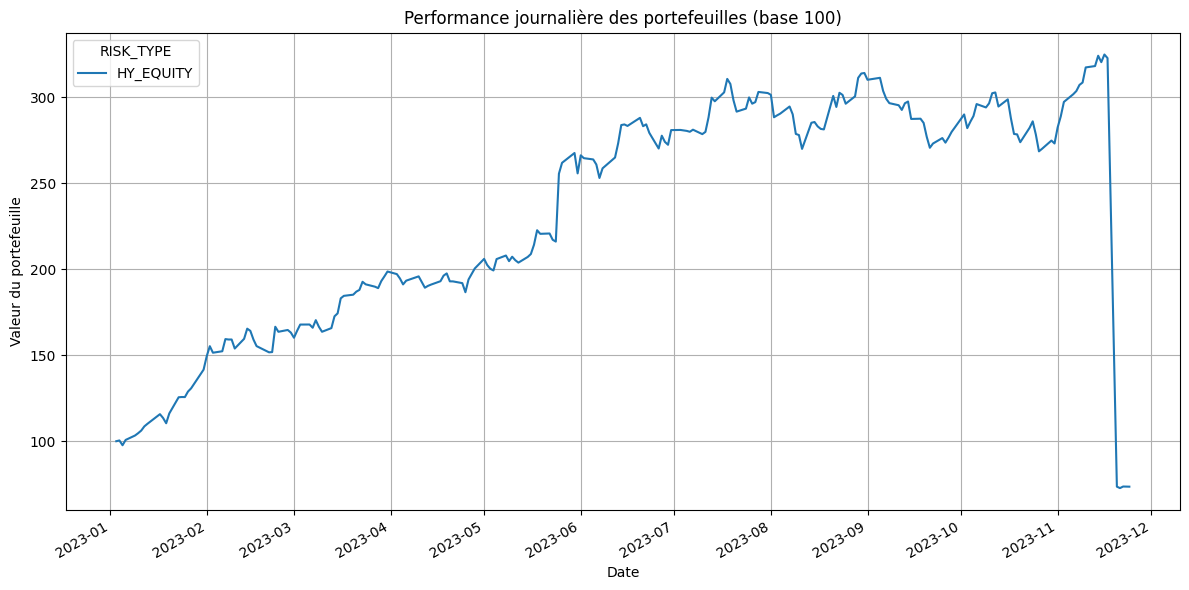

           Performance Totale (%)  Volatilité Annuelle (%)  Sharpe Ratio  \
HY_EQUITY                  -26.44                    91.74          0.58   

           Max Drawdown (%)  CAGR (%)  Meilleure Perf Hebdo (%)  \
HY_EQUITY            -77.61    -29.16                     18.72   

           Pire Perf Hebdo (%)  
HY_EQUITY                -77.2  
Le portefeuille HY_EQUITY du manager Scott Rodriguez affiche la performance totale la plus élevée (-26.44%).
Le portefeuille HY_EQUITY du manager Scott Rodriguez a la volatilité annuelle la plus faible (91.74%), illustrant une meilleure stabilité.
Le portefeuille HY_EQUITY du manager Scott Rodriguez présente le meilleur Sharpe Ratio (0.58), indiquant le couple rendement/risque le plus efficace.
Le portefeuille HY_EQUITY du manager Scott Rodriguez présente le plus faible drawdown (-77.61%), signe d'une bonne résistance en période de baisse.
Le portefeuille HY_EQUITY du manager Scott Rodriguez affiche le meilleur taux de croissance annualis

In [15]:
analyzer = PortfolioAnalyzer("Fund.db")
analyzer.plot_portfolio_performance()
metrics_df = analyzer.compute_portfolio_metrics()
print(metrics_df)
analyzer.describe_best_portfolios()
